# 1. Data Loading and Preprocessing

In [1]:
# Install required libraries (only run once)
!pip install --upgrade transformers datasets peft accelerate

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch
import logging
from transformers import AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F
from math import ceil
import numpy as np
import pandas as pd
import shutil
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import Dataset


# -------------------- 1. Data Loading and Preprocessing --------------------
# Load training and validation datasets
train_df = pd.read_csv('/kaggle/input/comp34812-cw-c-dataset/training_data/NLI/train.csv')
test_df = pd.read_csv('/kaggle/input/comp34812-cw-c-dataset/training_data/NLI/dev.csv')

# Split training data into train and validation sets (90% train, 10% validation)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    list(zip(train_df['premise'], train_df['hypothesis'])),
    train_df['label'].values,
    test_size=0.1,
    random_state=42
)

# Suppress tokenizer warning logs
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

# Tokenization function for sentence pairs (premise, hypothesis)
def encode(pairs):
    premises, hypotheses = zip(*pairs)
    return tokenizer(
        list(premises),
        list(hypotheses),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

# Tokenize the train, validation, and test datasets
train_encodings = encode(train_texts)
val_encodings = encode(val_texts)
test_encodings = encode(list(zip(test_df['premise'], test_df['hypothesis'])))

# Custom dataset class for PyTorch DataLoader
class NLIDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create dataset objects for training, validation, and test sets
train_dataset = NLIDataset(train_encodings, train_labels)
val_dataset = NLIDataset(val_encodings, val_labels)
test_dataset = NLIDataset(test_encodings)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 91.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.0/411.0 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvid

2025-04-11 03:35:56.830245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744342556.994342      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744342557.046608      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


# 2. Custom Trainer with Label Smoothing and Metric Computation

In [2]:
# -------------------- 2. Custom Trainer + Evaluation Metrics --------------------

# Custom Trainer class with label smoothing added to loss computation
class SmoothTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")  # Extract labels from inputs
        outputs = model(**inputs)      # Forward pass
        logits = outputs.logits        # Extract logits
        # Use cross-entropy loss with label smoothing
        loss = F.cross_entropy(logits, labels, label_smoothing=0.1)
        return (loss, outputs) if return_outputs else loss

# Custom metric computation function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # Convert logits to predicted class indices
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds)     # Use macro-F1 by default (can be specified)
    }


# 3. Hyperparameter Optimization with Optuna

In [3]:
# # -------------------- 3. Optuna Hyperparameter Tuning --------------------
# # For using the hardcoded parameter set from previous session and save time, please comment the whole cell out.
# def objective(trial):
#     # Sample learning rate (log-uniform)
#     learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
#     batch_size = 64

#     r = trial.suggest_categorical("r", [8, 16])
#     alpha = r * 3

#     # Sample dropout rate
#     dropout = trial.suggest_float("dropout", 0.1, 0.15)

#     # Define LoRA configuration for parameter-efficient fine-tuning
#     peft_config = LoraConfig(
#         r=r,
#         lora_alpha=alpha,
#         lora_dropout=dropout,
#         task_type=TaskType.SEQ_CLS,
#         bias="none"
#     )

#     # Load base model and apply LoRA
#     base_model = AutoModelForSequenceClassification.from_pretrained(
#         "microsoft/deberta-v3-base", 
#         num_labels=2
#     )
#     model = get_peft_model(base_model, peft_config)
    
#     # Training setup
#     num_epochs = 6
#     steps_per_epoch = ceil(len(train_dataset) / batch_size)
#     total_steps = steps_per_epoch * num_epochs
#     warmup_steps = int(total_steps * 0.06)


#     training_args = TrainingArguments(
#         output_dir='./optuna_trial',
#         evaluation_strategy='epoch',
#         save_strategy='no',                       
#         # save_total_limit=1,                           
#         learning_rate=learning_rate,
#         per_device_train_batch_size=batch_size,
#         per_device_eval_batch_size=batch_size,
#         num_train_epochs=num_epochs,
#         weight_decay=0.04,
#         load_best_model_at_end=False,
#         # metric_for_best_model="eval_loss", # Removed for saving disk quota
#         # greater_is_better=False,                      
#         logging_strategy='epoch',                       
#         max_grad_norm=1.0,
#         lr_scheduler_type='cosine',
#         warmup_steps=warmup_steps,
#         report_to='none',
#         fp16=True,   # Use mixed precision for faster training
#     )


#     # Initialize trainer with our custom loss and metric
#     trainer = SmoothTrainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=val_dataset,
#         compute_metrics=compute_metrics,
#         # Uncomment below to enable early stopping
#         # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
#     )

#     # Start training and evaluate after training
#     trainer.train()
#     eval_result = trainer.evaluate()

#     # Return the F1 score to guide the optimization
#     return eval_result["eval_f1"]

# # Create Optuna study to maximize F1 score
# study = optuna.create_study(direction="maximize")

# # Run optimization for 10 trials
# study.optimize(objective, n_trials=10, gc_after_trial=True)

# # Print the best hyperparameters
# print("Best hyperparameters:", study.best_params)

# 4. Final Training with Best Hyperparameters + Logging

In [4]:
# -------------------- 4. Retrain and Save Model with Best Hyperparameters + Logging --------------------
# # Rebuild model with best parameters from Optuna
# params = study.best_params

# Uncomment and manually fill in recorded parameter set if running in environments where Optuna history was interrupted (e.g., Kaggle sessions)
params = {
    "learning_rate": 4.74e-5,
    "r": 16,
    "alpha": 48,        # Optional: can use alpha = r * 3
    "dropout": 0.13,
    "batch_size": 64
}

# 4.1 Model configuration using PEFT (LoRA)
peft_config = LoraConfig(
    r=params["r"],
    lora_alpha=params["alpha"],
    lora_dropout=params["dropout"],
    task_type=TaskType.SEQ_CLS,
    bias="none"
)

# Load base model and apply LoRA configuration
base_model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=2)
model = get_peft_model(base_model, peft_config)

# 4.2 Scheduler setup
steps_per_epoch = ceil(len(train_dataset) / params["batch_size"])
total_steps = steps_per_epoch * 10  # 10 epochs
warmup_steps = int(total_steps * 0.06)  # 6% warmup

# 4.3 Training configuration
training_args = TrainingArguments(
    output_dir='./best_model',             # Save directory
    eval_strategy='epoch',           # Evaluate every epoch
    save_strategy='epoch',                 # Save model every epoch
    save_total_limit=1,                    # Keep only the best model to save disk quota
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=params["batch_size"],
    per_device_eval_batch_size=params["batch_size"],
    num_train_epochs=10,
    weight_decay=0.04,
    load_best_model_at_end=True,           # Automatically load best model
    metric_for_best_model="eval_loss",
    greater_is_better=False,               # Lower eval_loss is better
    logging_strategy='epoch',              # Log metrics every epoch
    fp16=True,                             # Use mixed-precision for faster training
    max_grad_norm=1.0,
    lr_scheduler_type='cosine',            # Cosine LR scheduler
    warmup_steps=warmup_steps,
    report_to='none',                      # Disable external logging
)

# 4.4 Initialize the Trainer with best hyperparameters
best_trainer = SmoothTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# 4.5 Train the model
print("Start training...")
best_trainer.train()

# 4.6 Extract logs from training history
train_logs = []
val_logs = []

for log in best_trainer.state.log_history:
    if 'eval_loss' in log:
        val_logs.append({
            'epoch': int(log['epoch']),
            'loss': log['eval_loss'],
            'acc': log['eval_accuracy'],
            'f1': log['eval_f1']
        })
    elif 'loss' in log and 'epoch' in log:
        train_logs.append({
            'epoch': int(log['epoch']),
            'loss': log['loss'],
            'acc': None  
        })

# # 4.7 Final evaluation on training set for accuracy (optional)
# print("Final evaluation on training set for accuracy...")
# train_preds = best_trainer.predict(train_dataset)
# train_labels = train_preds.label_ids
# train_pred_labels = np.argmax(train_preds.predictions, axis=-1)
# final_train_acc = accuracy_score(train_labels, train_pred_labels)
# print(f"Final Train Accuracy: {final_train_acc:.4f}")

# # Update training logs with final train accuracy (same for all epochs)
# for log in train_logs:
#     log["acc"] = final_train_acc

# # Print summary of logs for each epoch
# print("\n Summary of logs:")
# for t, v in zip(train_logs, val_logs):
#     print(f"Epoch {t['epoch']}: Train Loss = {t['loss']:.4f}, Val Loss = {v['loss']:.4f}, Val Acc = {v['acc']:.4f}, Val F1 = {v['f1']:.4f}")

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Start training...


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.650000,0.445780,0.862520,0.867403
2,0.420700,0.384133,0.887070,0.897778
3,0.380800,0.374791,0.898527,0.906697
4,0.365700,0.369901,0.902209,0.906823
5,0.355000,0.363931,0.907938,0.914155
6,0.349100,0.362656,0.908347,0.913978
7,0.343700,0.361033,0.912029,0.918095
8,0.341200,0.359956,0.911211,0.916763
9,0.338300,0.359945,0.912029,0.917403
10,0.337600,0.359860,0.912029,0.917466


# 5. Training Curves Visualization and Log Export

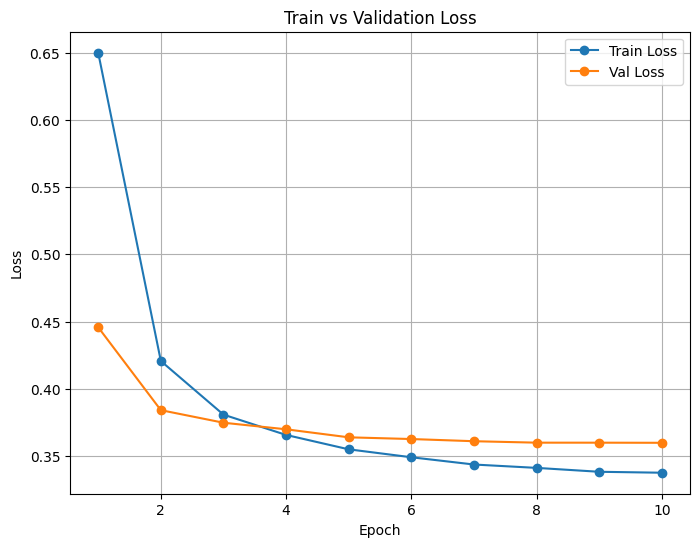

Saved loss curve to loss_curve.png


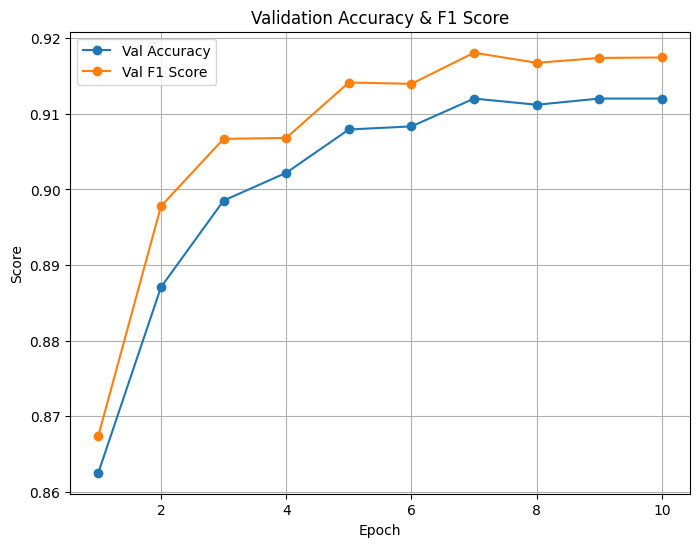

Saved accuracy + F1 curve to acc_f1_curve.png
Saved training logs to train_logs.csv and val_logs.csv


In [5]:
# -------------------- 5 Plot Line Graphs + Save Logs --------------------

epochs = [log["epoch"] for log in train_logs]
train_loss_vals = [log["loss"] for log in train_logs]
val_loss_vals = [log["loss"] for log in val_logs]
val_acc_vals = [log["acc"] for log in val_logs]
val_f1_vals = [log["f1"] for log in val_logs]

# ----------- Save & Display Loss Curve (Train + Validation) -----------
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_vals, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_vals, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/loss_curve.png')
plt.show()
plt.close()
print("Saved loss curve to loss_curve.png")

# ----------- Save & Display Accuracy + F1 Curve -----------
plt.figure(figsize=(8, 6))
plt.plot(epochs, val_acc_vals, label='Val Accuracy', marker='o')
plt.plot(epochs, val_f1_vals, label='Val F1 Score', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Accuracy & F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/acc_f1_curve.png')
plt.show()
plt.close()
print("Saved accuracy + F1 curve to acc_f1_curve.png")

# ----------- Save Training and Validation Logs as CSV -----------
train_log_df = pd.DataFrame(train_logs)
val_log_df = pd.DataFrame(val_logs)

train_log_df.to_csv("/kaggle/working/train_logs.csv", index=False)
val_log_df.to_csv("/kaggle/working/val_logs.csv", index=False)
print("Saved training logs to train_logs.csv and val_logs.csv")


# 6. Test Set Prediction and CSV Export

In [6]:
# -------------------- 6. Predict and Output to CSV --------------------
print("Generating predictions on test set...")
predictions = best_trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

df = pd.DataFrame({"prediction": preds})
df.to_csv("/kaggle/working/predictions.csv", index=False)
print("Saved predictions to predictions.csv")



Generating predictions on test set...


Saved predictions to predictions.csv


# 7. Save and Export the Trained Model

In [7]:
# -------------------- 7. Save Model --------------------
best_trainer.model.save_pretrained("/kaggle/working/best_model")
tokenizer.save_pretrained("/kaggle/working/best_model")
shutil.make_archive("/kaggle/working/best_model", 'zip', "/kaggle/working/best_model")
print("Saved best model and zipped it.")

# -------------------- 7.1 Save Fully Merged Model --------------------
# Merge LoRA adapter into base model to make a standalone version
print("Merging LoRA adapter into base model...")
merged_model = best_trainer.model.merge_and_unload()

# Save fully merged model that can be loaded without PEFT
merged_model.save_pretrained("/kaggle/working/best_model_full")
tokenizer.save_pretrained("/kaggle/working/best_model_full")
shutil.make_archive("/kaggle/working/best_model_full", 'zip', "/kaggle/working/best_model_full")
print("Saved fully merged model and zipped it.")


Saved best model and zipped it.
Merging LoRA adapter into base model...
Saved fully merged model and zipped it.
